In [1]:
%load_ext autoreload
%autoreload 2

import casadi as ca
import cyecca.lie as lie
from cyecca.symbolic import SERIES
from cyecca.util import rk4
import numpy as np
import matplotlib.pyplot as plt
from cyecca.lie.group_se23 import SE23LieGroupElement, SE23LieAlgebraElement
import math
import scipy.linalg
from pathlib import Path

In [2]:
def calculate_N(v: SE23LieAlgebraElement, B: ca.SX):
    omega = v.Omega
    Omega = omega.to_Matrix()
    OmegaSq = Omega @ Omega
    A = ca.sparsify(ca.horzcat(v.a_b.param, v.v_b.param))
    B = ca.sparsify(B)
    theta = ca.norm_2(omega.param)
    C1 = SERIES["(1 - cos(x))/x^2"](theta)
    C2 = SERIES["(x - sin(x))/x^3"](theta)
    C3 = SERIES["(x^2/2 + cos(x) - 1)/x^4"](theta)
    AB = A @ B
    I3 = ca.SX.eye(3)
    return (
        A
        + AB / 2
        + Omega @ A @ (C1 * np.eye(2) + C2 * B)
        + Omega @ Omega @ A @ (C2 * np.eye(2) + C3 * B)
    )

In [3]:
def exp_mixed(
    X0: SE23LieGroupElement,
    l: SE23LieAlgebraElement,
    r: SE23LieAlgebraElement,
    B: ca.SX,
):
    P0 = ca.horzcat(X0.v.param, X0.p.param)
    Pl = calculate_N(l, B)
    Pr = calculate_N(r, -B)
    R0 = X0.R
    Rl = (l).Omega.exp(lie.SO3Mrp)
    Rr = (r).Omega.exp(lie.SO3Mrp)
    Rr0 = Rr * R0
    R1 = Rr0 * Rl

    I2 = ca.SX.eye(2)
    P1 = Rr0.to_Matrix() @ Pl + (Rr.to_Matrix() @ P0 + Pr) @ (I2 + B)
    return lie.SE23Mrp.elem(ca.vertcat(P1[:, 1], P1[:, 0], R1.param))


def derive_strapdown_ins_propagation():
    dt = ca.SX.sym("dt")
    X0 = lie.SE23Mrp.elem(ca.SX.sym("X0", 9))
    a_b = ca.SX.sym("a_b", 3)
    g = ca.SX.sym("g")
    omega_b = ca.SX.sym("omega_b", 3)
    l = lie.se23.elem(ca.vertcat(0, 0, 0, a_b, omega_b))
    r = lie.se23.elem(ca.vertcat(0, 0, 0, 0, 0, g, 0, 0, 0))
    B = ca.sparsify(ca.SX([[0, 1], [0, 0]]))
    X1 = exp_mixed(X0, l * dt, r * dt, B * dt)
    r1 = lie.SO3Mrp.elem(X1.param[6:9])
    lie.SO3Mrp.shadow_if_necessary(r1)
    X1.param[6:9] = r1.param
    return ca.Function(
        "strapdown_ins_propagate",
        [X0.param, a_b, omega_b, g, dt],
        [X1.param],
        ["x0", "a_b", "omega_b", "g", "dt"],
        ["x1"],
    )


f_strapdown_ins_propagation = derive_strapdown_ins_propagation()

In [4]:
res = f_strapdown_ins_propagation(
    [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0], [0, 0, 0], 9.8, 10
)
res

DM([0, 0, 490, 0, 0, 98, 0, 0, 0])

In [5]:
r = lie.SO3Mrp.elem(ca.SX.sym("r", 3))
euler = lie.SO3EulerB321.from_Mrp(r)
f_r_to_eulerB321 = ca.Function("r_to_eulerB321", [r.param], [euler.param])

In [6]:
%%timeit
f_strapdown_ins_propagation(
    [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3], [0, 0, -9.8], [0, -0.1, 0], 9.8, 1
)

28.8 μs ± 107 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
lie.SO3Mrp.elem(ca.vertcat(0, 0, 0)).to_Matrix()

SX(@1=1, 
[[@1, 00, 00], 
 [00, @1, 00], 
 [00, 00, @1]])

In [8]:
def derive_rk4_kinematics():
    x = ca.SX.sym("x0", 9)
    a_b = ca.SX.sym("a_b", 3)
    omega_b = ca.SX.sym("omega_b", 3)
    g = ca.SX.sym("g")
    p, v, r = x[:3], x[3:6], x[6:9]
    R = lie.SO3Mrp.elem(r).to_Matrix()
    p_dot = v
    v_dot = R @ a_b + ca.vertcat(0, 0, g)

    X = lie.so3.elem(r).to_Matrix()
    n_sq = ca.dot(r, r)
    B = 0.25 * ((1 - n_sq) * ca.SX.eye(3) + 2 * X + 2 * r @ r.T)
    r_dot = B @ omega_b
    return ca.Function(
        "ode_dynamics",
        [x, a_b, omega_b, g],
        [ca.vertcat(p_dot, v_dot, r_dot)],
        ["x", "a_b", "omega_b", "g"],
        ["x_dot"],
    )

In [9]:
def derive_integrate_rk4():
    x0 = ca.SX.sym("x0", 9)
    dt = ca.SX.sym("dt")
    a_b = ca.SX.sym("a_b", 3)
    g = ca.SX.sym("g")
    omega_b = ca.SX.sym("omega_b", 3)
    f_rk4_kinematics = derive_rk4_kinematics()
    x1 = rk4(lambda t, x: f_rk4_kinematics(x, a_b, omega_b, g), 0, x0, dt)
    r1 = lie.SO3Mrp.elem(x1[6:9])
    lie.SO3Mrp.shadow_if_necessary(r1)
    x1[6:9] = r1.param
    return ca.Function(
        "integrate_rk4",
        [x0, a_b, omega_b, g, dt],
        [x1[:, 0]],
        ["x0", "a_b", "omega_b", "g", "dt"],
        ["x1"],
    )


f_integrate_rk4 = derive_integrate_rk4()
f_integrate_rk4([0, 0, 0, 0, 0, 0, 0, 0, 0], [0.1, 0.2, 0.3], [0.1, 0.2, 0.3], 9.8, 0.1)

DM([0.0005, 0.001, 0.0505, 0.01, 0.02, 1.01, 0.00250007, 0.00500015, 0.00750022])

In [10]:
%%timeit
f_integrate_rk4(
    [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3], [0, 0, -9.8], [0, -0.1, 0], 9.8, 1
)

30 μs ± 254 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
def integrate_rk4(x0, a_b, omega_b, g, dt, tf):
    t_list = np.arange(0, tf, dt)
    data = {"t": t_list, "x": np.zeros((len(t_list), len(x0)), dtype=float)}
    x = data["x"]
    x[0, :] = x0
    for i in range(1, len(t_list)):
        x[i, :] = np.array(f_integrate_rk4(x[i - 1, :], a_b, omega_b, g, dt)).reshape(
            -1
        )
    return data


def integrate_mixed_invariant(x0, a_b, omega_b, g, dt, tf):
    t_list = np.arange(0, tf, dt)
    data = {"t": t_list, "x": np.zeros((len(t_list), len(x0)), dtype=float)}
    x = data["x"]

    x[0, :] = x0
    for i in range(1, len(t_list)):
        x[i, :] = np.array(
            f_strapdown_ins_propagation(x0, a_b, omega_b, g, t_list[i])
        ).reshape(-1)
    return data

In [12]:
from pathlib import Path


def comparison(name: str, a_b: np.array, omega_b: np.array):
    fig_path = Path("fig")
    fig_path.mkdir(exist_ok=True)
    dt = 0.005
    tf = 10
    g = 9.8

    # pos, vel, rot
    x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    data_rk4 = integrate_rk4(x0=x0, a_b=a_b, omega_b=omega_b, g=g, dt=dt, tf=tf)

    data_mixed = integrate_mixed_invariant(
        x0=x0, a_b=a_b, omega_b=omega_b, g=g, dt=dt, tf=tf
    )

    if True:
        plt.figure()
        plt.title("Modified Rodrigues Parameters Comparison")
        h_rk4 = plt.plot(data_rk4["t"], data_rk4["x"][:, 7:10], "r-", linewidth=5)[0]
        h_mixed = plt.plot(data_mixed["t"], data_mixed["x"][:, 7:10], "y-")[0]
        plt.legend([h_rk4, h_mixed], ["rk4", "mixed"])
        plt.xlabel("t, sec")
        plt.ylabel("mrp components")
        plt.grid()
        plt.savefig(f"fig/mrp_{name:s}.png")

    if True:
        plt.figure()
        plt.title("Mrp Error in RK4 Method")
        plt.plot(
            data_rk4["t"],
            data_rk4["x"][:, 7:10] - data_mixed["x"][:, 7:10],
            "r-",
            linewidth=5,
            label="rk4",
        )
        plt.xlabel("t, sec")
        plt.ylabel("mrp error")
        plt.grid()
        plt.savefig(f"fig/mrp_error_{name:s}.png")

    if False:
        plt.figure()
        plt.title("positon")
        h_rk4 = plt.plot(data_rk4["t"], data_rk4["x"][:, 0], "r.-", linewidth=10)[0]
        h_mixed = plt.plot(data_mixed["t"], data_mixed["x"][:, 0], "y.-")[0]
        plt.legend([h_rk4, h_mixed], ["rk4", "mixed"])
        plt.xlabel("t, sec")
        plt.ylabel("position")
        plt.grid()
        plt.savefig(f"fig/pos_{name:s}.png")

    if False:
        plt.figure()
        plt.title("position error")
        plt.plot(data_rk4["t"], data_rk4["x"][:, 0] - data_mixed["x"][:, 0], "r.-")
        plt.xlabel("t, sec")
        plt.grid()
        plt.savefig(f"fig/pos_error_{name:s}.png")

    if True:
        plt.figure()
        plt.title("Trajectory Comparison in XZ-plane")
        h_rk4 = plt.plot(
            data_rk4["x"][:, 0], -data_rk4["x"][:, 2], "r-", linewidth=5, label="rk4"
        )[0]
        h_mixed = plt.plot(
            data_mixed["x"][:, 0], -data_mixed["x"][:, 2], "y-", label="mixed"
        )[0]
        plt.xlabel("t, sec")
        plt.legend([h_rk4, h_mixed], ["rk4", "mixed"])
        plt.grid()
        plt.savefig(f"fig/traj_xz_{name:s}.png")

In [13]:
from cyecca.graph import draw_casadi
import casadi.tools

In [14]:
def draw_graphs():
    x0 = ca.SX.sym("x0", 9)
    a_b = ca.SX.sym("a_b", 3)
    omega_b = ca.SX.sym("omega_b", 3)
    g = ca.SX.sym("g")
    dt = ca.SX.sym("dt")
    draw_casadi(
        f_strapdown_ins_propagation(x0, a_b, omega_b, g, dt),
        filename="fig/f_mixed.png",
        width=400,
    )
    draw_casadi(
        f_integrate_rk4(x0, a_b, omega_b, g, dt), filename="fig/f_rk4.png", width=400
    )


# draw_graphs()

In [15]:
import casadi as ca
import casadi.tools
from casadi import SX, MX, print_operator


def count_ops(s, ops=None, dep=None, invdep=None):
    """
    count ops in expression
    """
    import casadi

    from ipywidgets import IntProgress
    from IPython.display import display

    if dep is None:
        dep = {}
    if invdep is None:
        invdep = {}

    op_str = {
        eval("casadi." + item): item for item in dir(casadi) if item.startswith("OP_")
    }
    if ops is None:
        ops = {}

    try:

        def getHashSX(e):
            if e.is_scalar(True):
                try:
                    return e.element_hash()
                except:
                    return SX__hash__backup(e)
            else:
                return 0

        SX__hash__backup = casadi.SX.__hash__
        casadi.SX.__hash__ = getHashSX
        print("building dependency graph...", end="")
        dep, invdep = casadi.tools.graph.dependencyGraph(s, dep, invdep)
        print("done")
        allnodes = set(dep.keys()).union(set(invdep.keys()))
        n = len(allnodes)
        progress = IntProgress(min=0, max=n)
        display(progress)
        for i, node in enumerate(allnodes):
            progress.value = i
            if node.is_scalar():
                op = node.op()
                op_name = op_str[op]
                if op_name in ops:
                    ops[op_name] += 1
                else:
                    ops[op_name] = 1
    finally:
        casadi.SX.__hash__ = SX__hash__backup
    return ops

In [16]:
x = casadi.SX.sym("x")
count_ops(casadi.vertcat(2 * x + 3, x))

building dependency graph...done


IntProgress(value=0, max=6)

{'OP_ADD': 1, 'OP_MUL': 1, 'OP_PARAMETER': 1, 'OP_CONST': 2}

In [17]:
x0 = ca.SX.sym("x0", 9)
a_b = ca.SX.sym("a_b", 3)
omega_b = ca.SX.sym("omega_b", 3)
g = ca.SX.sym("g")
dt = ca.SX.sym("dt")

op_dict_mixed = count_ops(f_strapdown_ins_propagation(x0, a_b, omega_b, g, dt))
op_dict_mixed

building dependency graph...done


IntProgress(value=0, max=394)

{'OP_SUB': 25,
 'OP_SQ': 44,
 'OP_NEG': 6,
 'OP_CONST': 16,
 'OP_MUL': 120,
 'OP_ADD': 88,
 'OP_FABS': 3,
 'OP_DIV': 29,
 'OP_IF_ELSE_ZERO': 25,
 'OP_PARAMETER': 17,
 'OP_LT': 6,
 'OP_SQRT': 4,
 'OP_REMAINDER': 1,
 'OP_TAN': 1,
 'OP_NOT': 5,
 'OP_COS': 2,
 'OP_SIN': 1}

In [18]:
op_dict_rk4 = count_ops(f_integrate_rk4(x0, a_b, omega_b, g, dt))
op_dict_rk4

building dependency graph...done


IntProgress(value=0, max=701)

{'OP_ADD': 181,
 'OP_DIV': 60,
 'OP_MUL': 322,
 'OP_IF_ELSE_ZERO': 6,
 'OP_SQ': 58,
 'OP_SUB': 44,
 'OP_PARAMETER': 17,
 'OP_LT': 1,
 'OP_NEG': 3,
 'OP_CONST': 6,
 'OP_NOT': 1,
 'OP_SQRT': 1}

In [19]:
def find_flops(op_dict):
    flops = 0
    for k, v in op_dict.items():
        if k not in ["OP_PARAMETER", "OP_CONST"]:
            flops += v
    return flops

In [20]:
flops_mixed = find_flops(op_dict_mixed)

In [21]:
flops_rk4 = find_flops(op_dict_rk4)

In [22]:
print(flops_rk4, flops_mixed)

677 360


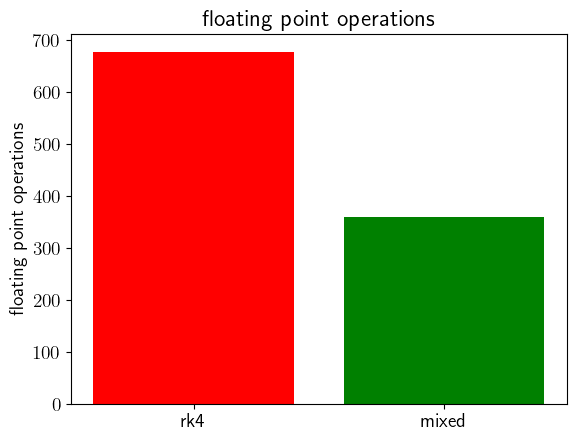

In [22]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['text.usetex'] = True

plt.title("floating point operations")
plt.bar(x=["rk4", "mixed"], height=[flops_rk4, flops_mixed], color=["r", "g"])
plt.ylabel("floating point operations")
Path("fig").mkdir(exist_ok=True)
plt.savefig("fig/ops.pdf", dpi=300)

In [23]:
def derive_f_quat_from_mrp():
    r = lie.SO3Mrp.elem(ca.SX.sym("r", 3))
    q = lie.SO3Quat.from_Mrp(r)
    return ca.Function("quat_from_mrp", [r.param], [q.param], ["r"], ["q"])


f_quat_from_mrp = derive_f_quat_from_mrp()

In [24]:
from cyecca.codegen import generate_code

In [25]:
generate_code(
    eqs={
        "strapdown_ins": {
            "predict": f_strapdown_ins_propagation,
            "quat_from_mrp": f_quat_from_mrp,
        },
    },
    dest_dir="gen",
)

In [28]:
def comparison_tolerance(name: str, x0: np.array, a_b: np.array, omega_b: np.array):
    plt.close()
    fig_path = Path("fig")
    fig_path.mkdir(exist_ok=True)
    tf = 10
    g = 9.8

    rk4_steps = [10 ** (-n) for n in range(1, 4)]
    print(rk4_steps)

    plt.ioff()

    plt.figure(1)
    # plt.title(
    #    f"{name:s} Error in Runge-Kutta 4th Order Method"
    # )
    plt.ylabel("$log_{10} |e|$")
    plt.xlabel("t, sec")
    plt.grid()

    plt.figure(2)
    # plt.title(f"Trajectory")
    plt.xlabel("x, m")
    plt.ylabel("y, m")
    plt.grid()
    plt.axis("equal")

    plt.figure(3)
    # plt.title("mrp yaw")

    plt.figure(4)
    # plt.title("vx")

    plt.figure(5)
    # plt.title("vy")

    plt.figure(6)
    # plt.title("x")

    plt.figure(7)
    # plt.title("y")

    plt.figure(8)
    # plt.title("yaw angle, deg")

    for step in rk4_steps:
        data_rk4 = integrate_rk4(x0=x0, a_b=a_b, omega_b=omega_b, g=g, dt=step, tf=tf)
        data_mixed = integrate_mixed_invariant(
            x0=x0, a_b=a_b, omega_b=omega_b, g=g, dt=step, tf=tf
        )
        e = np.linalg.norm(data_rk4["x"] - data_mixed["x"], axis=1)
        e = np.where(e == 0, 1e-15, e)
        log_e = np.log10(np.abs(e))

        # plt.subplot(121)
        # plt.plot(data_rk4[step]['t'], e)
        # plt.title(f'step {step:f}')
        # plt.ylabel('e')
        # plt.xlabel('t, s')

        # plt.subplot(122)
        plt.figure(1)
        plt.plot(data_rk4["t"], log_e, label=f"step size: {step:10g}")

        plt.figure(2)
        plt.plot(
            data_rk4["x"][:, 0], data_rk4["x"][:, 1], label=f"step size: {step:10g}"
        )

        plt.figure(3)
        plt.plot(data_rk4["t"], data_rk4["x"][:, 8], label=f"step size: {step:10g}")

        plt.figure(4)
        plt.plot(data_rk4["t"], data_rk4["x"][:, 3], label=f"step size: {step:10g}")

        plt.figure(5)
        plt.plot(data_rk4["t"], data_rk4["x"][:, 4], label=f"step size: {step:10g}")

        plt.figure(6)
        plt.plot(data_rk4["t"], data_rk4["x"][:, 0], label=f"step size: {step:10g}")

        plt.figure(7)
        plt.plot(data_rk4["t"], data_rk4["x"][:, 1], label=f"step size: {step:10g}")

        plt.figure(8)
        plt.plot(
            data_rk4["t"],
            np.rad2deg(np.arctan2(data_rk4["x"][:, 0], data_rk4["x"][:, 1])),
            label=f"step size: {step:10g}",
        )

    plt.figure(1)
    plt.legend(loc="best")
    plt.savefig(f"fig/{name:s}_tol.png")
    # plt.close(1)

    plt.figure(2)
    plt.legend()
    plt.savefig(f"fig/{name:s}_traj.png")
    # plt.close(2)

    plt.figure(3)
    plt.savefig(f"fig/{name:s}_mrp_yaw.png")
    plt.close(3)

    plt.close(4)
    plt.close(5)
    plt.close(6)
    plt.close(7)

    plt.figure(8)
    # plt.title("yaw angle, deg")
    plt.savefig(f"fig/{name:s}_yaw.png")
    plt.close()

    plt.show()
    plt.close()

[0.1, 0.01, 0.001]


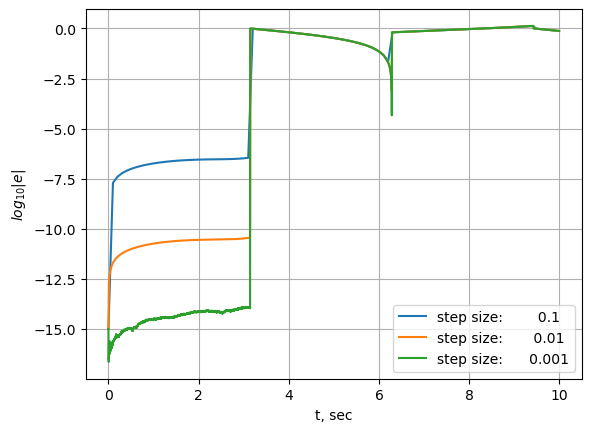

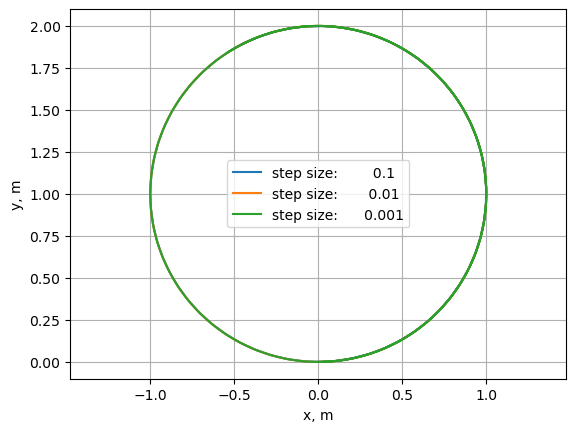

In [29]:
def circle_comparison():
    vx0 = 1
    r = 1
    ay = vx0**2 / r
    theta_dot = vx0 / r
    comparison_tolerance(
        "circle", [0, 0, 0, vx0, 0, 0, 0, 0, 0], [0, ay, -9.8], [0, 0, theta_dot]
    )


circle_comparison()

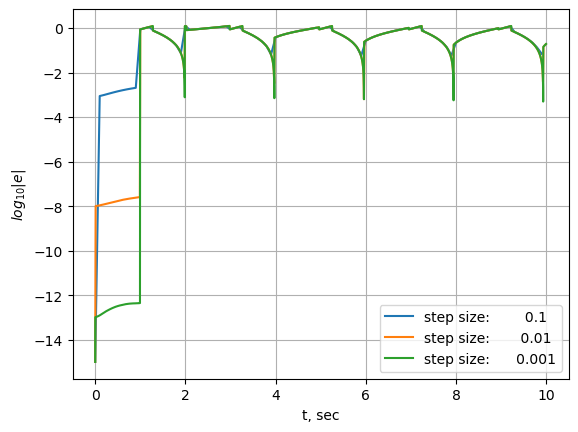

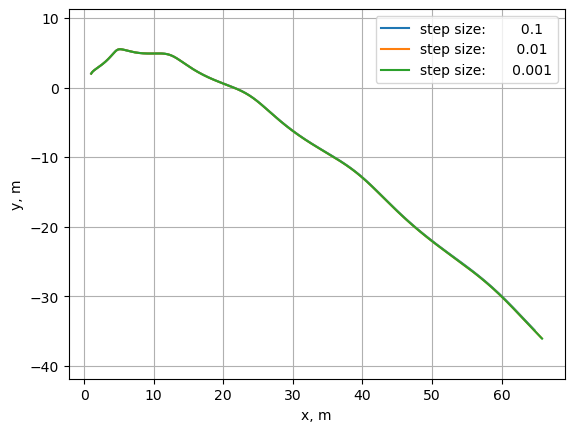

In [23]:
comparison_tolerance(
    "aggressive", [1, 2, 3, 1, 2, 3, 1, 2, 3], [1, 2, -9.8 + 3], [1, 0, 3]
)